# Zachary Brooks 
### Sells and invests in historical houses, best neighborhoods, high profits, best timing within a year, should renovate ? 

    Arguments: 
    - Define historical houses 
    - Define best neighborhoods
    - Define best timing within a year
    - Client asks if he should renovate the houses

## Agenda
### Step 0: Import packages etc
### Step 1: Investment overview
### Step 2: Best selling month
### Step 3: Renovation necessity
### Step 4: Key price drivers 
### Step 5: Other correlations

# Step 0: 
## Import packages and cleaned up data

In [37]:
# Import packages, open connection, define query string and read data

# Import packages
import pandas as pd # to read sql data into a pandas dataframe
import psycopg2 # to connect to SQL database
import os # provides functions for interacting with operating system
from dotenv import load_dotenv # reads key-value pairs from a .env file and can set them as environment variables
import matplotlib.pyplot as plt
import seaborn as sns
load_dotenv() # takes environment variables from .env

DATABASE = os.getenv('DATABASE')
USER_DB = os.getenv('USER_DB')
PASSWORD = os.getenv('PASSWORD')
HOST = os.getenv('HOST')
PORT = os.getenv('PORT')

# Open connection 
conn = psycopg2.connect(
    database=DATABASE,
    user=USER_DB,
    password=PASSWORD,
    host=HOST,
    port=PORT
)

# Use cleaned up dataframe 
file_path = 'df_eda.csv'
df_eda_cleaned = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to confirm it's loaded correctly
df_eda_cleaned.head()


,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date,price
0,7129300520,3.0,1.00,1180.0,5650.0,1.0,0.0,0.0,3,7,...,0.0,1955,0,98178,47.51,-122.26,1340.0,5650.0,2014-10-13,221900.0
1,6414100192,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,3,7,...,400.0,1951,1991,98125,47.72,-122.32,1690.0,7639.0,2014-12-09,538000.0
2,5631500400,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,3,6,...,0.0,1933,0,98028,47.74,-122.23,2720.0,8062.0,2015-02-25,180000.0
3,2487200875,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,5,7,...,910.0,1965,0,98136,47.52,-122.39,1360.0,5000.0,2014-12-09,604000.0
4,1954400510,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,3,8,...,0.0,1987,0,98074,47.62,-122.04,1800.0,7503.0,2015-02-18,510000.0


# Step 1: 

# Give an investment overview of relevant objects 
### Filter out historical houses (min. 50yr old) and best neighborhoods (top 10)

In [3]:

# 1. Identify historical houses
current_year = pd.to_datetime('today').year
df_eda_cleaned['yr_built'] = pd.to_numeric(df_eda_cleaned['yr_built'], errors='coerce')  # Ensure 'yr_built' is numeric
historical_houses = df_eda_cleaned[df_eda_cleaned['yr_built'] < 1974] # Historic houses are min. 50yr old

# 2. Define the best neighborhoods
# Group by zip code and calculate average house price
average_prices = df_eda_cleaned.groupby('zipcode')['price'].mean().reset_index()

# Define a threshold for "good" neighborhoods
price_threshold = 807000  # Defined own threshold based on top 10 avr. house prices/ zip code
good_neighborhoods = average_prices[average_prices['price'] > price_threshold]

# Extract the list of good zip codes
good_neighborhoods_zipcodes = good_neighborhoods['zipcode'].tolist()

# 3. Filter historical houses for those in the good neighborhoods
historical_houses_in_good_neighborhoods = historical_houses[historical_houses['zipcode'].isin(good_neighborhoods_zipcodes)]

# Save all info on relevant objects for client in new CSV file
historical_houses_in_good_neighborhoods.to_csv('historical_houses_in_good_neighborhoods.csv', index=False)



In [4]:
# Output of relevant objects for client to invest in 
historical_houses_in_good_neighborhoods.head()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date,price
21,2524049179,3.0,2.75,3050.0,44867.0,1.0,0.0,4.0,3,9,...,720.0,1968,0,98040,47.53,-122.23,4110.0,20336.0,2014-08-26,2000000.0
26,1794500383,3.0,1.75,2450.0,2691.0,2.0,0.0,0.0,3,8,...,700.0,1915,0,98119,47.64,-122.36,1760.0,3573.0,2014-06-26,937000.0
27,3303700376,3.0,1.00,1400.0,1581.0,1.5,0.0,0.0,5,8,...,0.0,1909,0,98112,47.62,-122.31,1860.0,3861.0,2014-12-01,667000.0
43,9270200160,3.0,1.00,1570.0,2280.0,2.0,0.0,0.0,3,7,...,0.0,1922,0,98119,47.64,-122.36,1580.0,2640.0,2014-10-28,685000.0
54,4217401195,5.0,2.25,2730.0,6000.0,1.5,0.0,0.0,3,8,...,600.0,1927,0,98105,47.66,-122.28,2730.0,6000.0,2015-03-03,920000.0


In [13]:
num_rows = data.shape[0]

print(f'Their are {num_rows} relevant objects.')

Their are 1346 relevant objects.


In [82]:
#map relevant output 
import folium
data = pd.read_csv('historical_houses_in_good_neighborhoods.csv')

# Create a map centered around the average latitude and longitude
center_lat = data['lat'].mean()
center_lon = data['long'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# Add markers with multiple popups
for _, row in data.iterrows():
    # Check if yr_renovated is 0 and replace with '-'
    yr_renovated = row['yr_renovated'] if row['yr_renovated'] != 0 else '-'
    
    popup_content = f"""
    <strong>House ID:</strong> {row['id']}<br>
    <strong>Price:</strong> ${row['price']:,.2f}<br>
    <strong>Year Built:</strong> {row['yr_built']}<br>
    <strong>Year Renovated:</strong> {yr_renovated}<br>
    """
    folium.Marker(
        location=[row['lat'], row['long']],
        popup=folium.Popup(popup_content, max_width=300)
    ).add_to(m)

m

# Step 2: 

# Identify the best time of the year to sell houses for maximum profit.
### Analyse seasonal trends & plot data

/var/folders/mv/6m38j0cs28b4zwc_3g6h8jkh0000gn/T/ipykernel_33813/270157966.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_prices = df_eda_cleaned.groupby('month')['price'].mean()


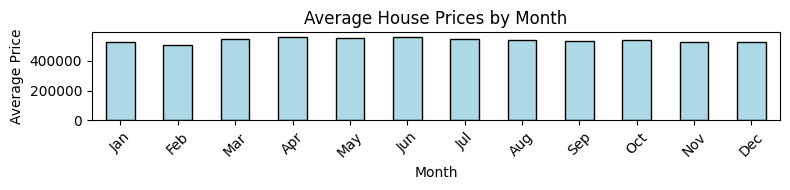

In [22]:
#entire dataset --> Very unclear which timing is best

# Convert 'date' to datetime
df_eda_cleaned['date'] = pd.to_datetime(df_eda_cleaned['date'])

# Extract month and year
df_eda_cleaned['month'] = df_eda_cleaned['date'].dt.month
df_eda_cleaned['year'] = df_eda_cleaned['date'].dt.year

# Ensure 'month' is treated as a categorical type with the correct order
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_eda_cleaned['month'] = pd.Categorical(df_eda_cleaned['month'], categories=range(1, 13), ordered=True)

# Calculate average price per month
monthly_prices = df_eda_cleaned.groupby('month')['price'].mean()

# Plot monthly average prices
plt.figure(figsize=(8, 2))
monthly_prices.plot(kind='bar', color='lightblue', edgecolor='black')
plt.title('Average House Prices by Month')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.xticks(ticks=range(12), labels=month_order, rotation=45)
plt.tight_layout()  # Adjust layout
plt.show()


In [ ]:
#entire dataset: Best month to sell is April
monthly_prices.sort_values()

month
2    508520
11   522360
12   524800
1    525963
9    529724
8    536655
10   539439
3    544058
7    544892
5    550850
6    557534
4    562216
Name: price, dtype: float64

/var/folders/mv/6m38j0cs28b4zwc_3g6h8jkh0000gn/T/ipykernel_33813/2622644662.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historical_houses_in_good_neighborhoods['date'] = pd.to_datetime(historical_houses_in_good_neighborhoods['date'])
/var/folders/mv/6m38j0cs28b4zwc_3g6h8jkh0000gn/T/ipykernel_33813/2622644662.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historical_houses_in_good_neighborhoods['month'] = historical_houses_in_good_neighborhoods['date'].dt.month
/var/folders/mv/6m38j0cs28b4zwc_3g

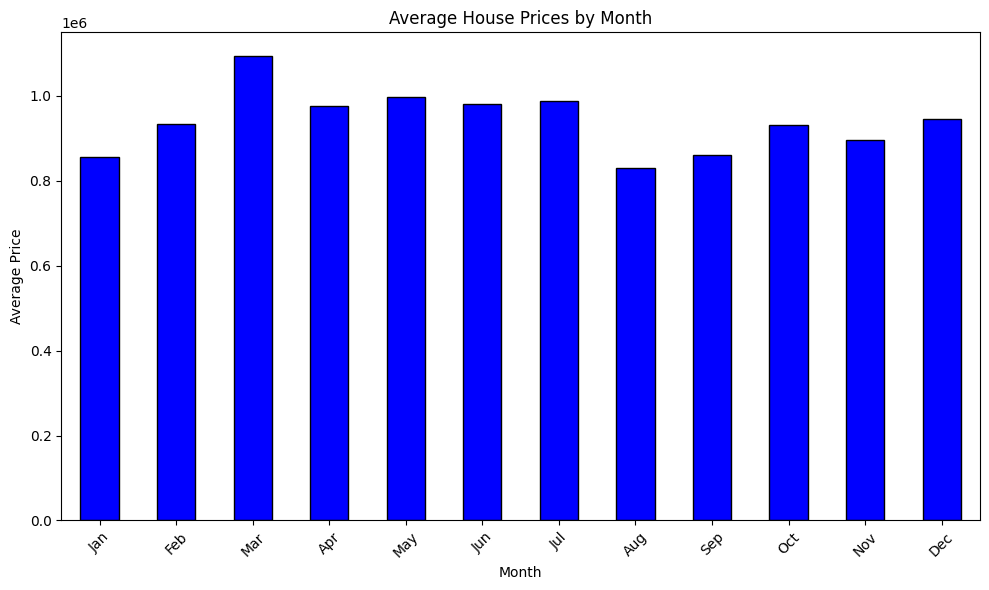

In [23]:
# use filtered historical_houses_in_good_neighborhoods DataFrame for relevant objects

# Convert 'date' to datetime
historical_houses_in_good_neighborhoods['date'] = pd.to_datetime(historical_houses_in_good_neighborhoods['date'])

# Extract month and year
historical_houses_in_good_neighborhoods['month'] = historical_houses_in_good_neighborhoods['date'].dt.month
historical_houses_in_good_neighborhoods['year'] = historical_houses_in_good_neighborhoods['date'].dt.year

# Ensure 'month' is treated as a categorical type with the correct order
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
historical_houses_in_good_neighborhoods['month'] = pd.Categorical(
    historical_houses_in_good_neighborhoods['month'],
    categories=range(1, 13),
    ordered=True
)

# Calculate average price per month
monthly_prices = historical_houses_in_good_neighborhoods.groupby('month')['price'].mean()

# Plot monthly average prices
plt.figure(figsize=(10, 6))
monthly_prices.plot(kind='bar', color='blue', edgecolor='black')
plt.title('Average House Prices by Month')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.xticks(ticks=range(12), labels=month_order, rotation=45)
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()


In [ ]:
#filtered dataset: Best month to sell is March
monthly_prices = historical_houses_in_good_neighborhoods.groupby('month')['price'].mean()
monthly_prices.sort_values()

/var/folders/mv/6m38j0cs28b4zwc_3g6h8jkh0000gn/T/ipykernel_13095/1017357904.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_prices = historical_houses_in_good_neighborhoods.groupby('month')['price'].mean()


month
8     829949
1     856774
9     860761
11    895244
10    931804
2     934835
12    944984
4     976749
6     981295
7     988717
5     996670
3    1095096
Name: price, dtype: float64

/var/folders/mv/6m38j0cs28b4zwc_3g6h8jkh0000gn/T/ipykernel_33813/2290996690.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historical_houses_in_good_neighborhoods['date'] = pd.to_datetime(historical_houses_in_good_neighborhoods['date'])
/var/folders/mv/6m38j0cs28b4zwc_3g6h8jkh0000gn/T/ipykernel_33813/2290996690.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historical_houses_in_good_neighborhoods['month'] = historical_houses_in_good_neighborhoods['date'].dt.month


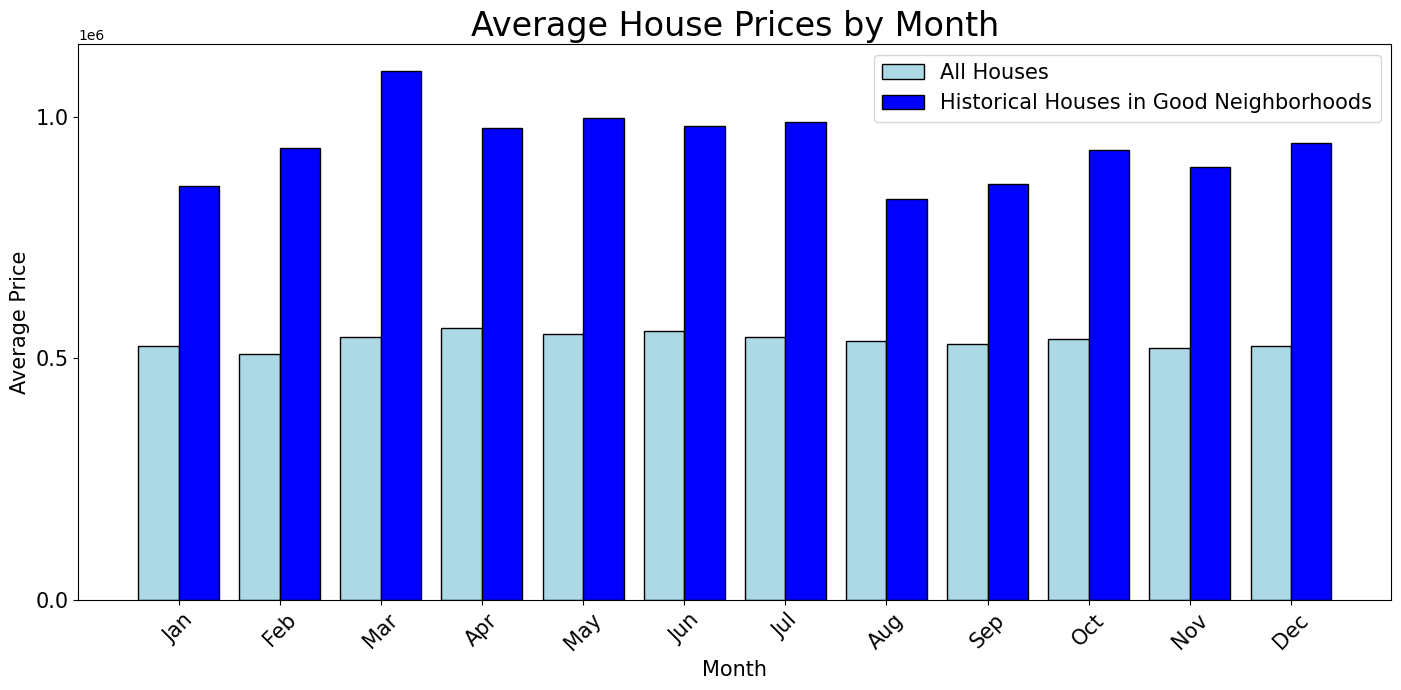

In [24]:
# Compare entire dataset and historical_houses in good neighborhood

# Convert 'date' to datetime in both DataFrames
df_eda_cleaned['date'] = pd.to_datetime(df_eda_cleaned['date'])
historical_houses_in_good_neighborhoods['date'] = pd.to_datetime(historical_houses_in_good_neighborhoods['date'])

# Extract month and year
df_eda_cleaned['month'] = df_eda_cleaned['date'].dt.month
historical_houses_in_good_neighborhoods['month'] = historical_houses_in_good_neighborhoods['date'].dt.month

# Calculate average price per month for both DataFrames
monthly_prices_df_eda = df_eda_cleaned.groupby('month')['price'].mean()
monthly_prices_good_neigh = historical_houses_in_good_neighborhoods.groupby('month')['price'].mean()

# Ensure the months are treated as categorical with the correct order
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_prices_df_eda = monthly_prices_df_eda.reindex(range(1, 13)).fillna(0)
monthly_prices_good_neigh = monthly_prices_good_neigh.reindex(range(1, 13)).fillna(0)

# Plotting
plt.figure(figsize=(14, 7))

# Plot for df_eda
plt.bar(monthly_prices_df_eda.index - 0.2, monthly_prices_df_eda, width=0.4, label='All Houses', color='lightblue', edgecolor='black')

# Plot for historical houses in good neighborhoods
plt.bar(monthly_prices_good_neigh.index + 0.2, monthly_prices_good_neigh, width=0.4, label='Historical Houses in Good Neighborhoods', color='blue', edgecolor='black')

# Customize plot
plt.title('Average House Prices by Month', fontsize=24)
plt.xlabel('Month', fontsize=15)
plt.ylabel('Average Price', fontsize=15)
plt.xticks(ticks=range(1, 13), labels=month_order, rotation=45, fontsize=15)
plt.legend(fontsize=15)
plt.tight_layout()  # Adjust layout to make room for labels
y_ticks = range(0, int(max(monthly_prices_df_eda.max(), monthly_prices_good_neigh.max())) + 1, 500000)  # Adjust step size here
plt.yticks(ticks=y_ticks, fontsize=15)

# Show plot
plt.show()


# Step 3: 

# Determine whether renovating houses increases their selling price and if so, by how much.
### Analyse renovation impact, visualise and compare

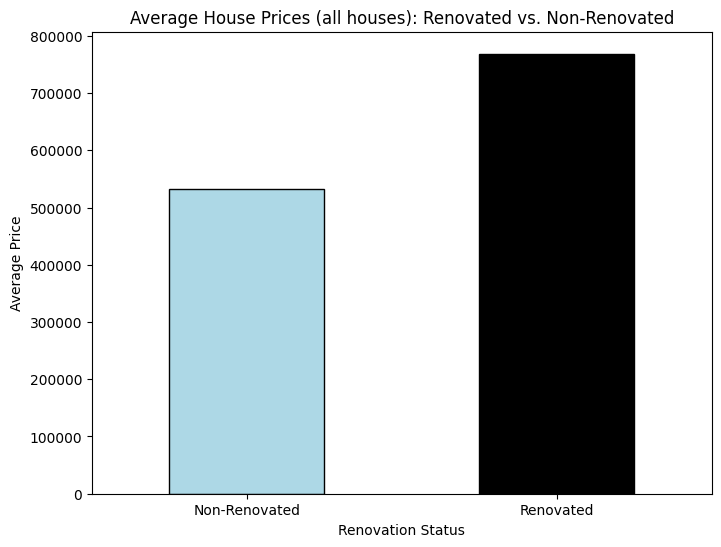

In [75]:
#Whole dataset (all houses)
# Create a new column for renovation status
df_eda_cleaned['renovated'] = df_eda_cleaned['yr_renovated'].apply(lambda x: pd.notnull(x) and x != 0)


# Calculate average prices for renovated and non-renovated houses
renovation_prices = df_eda_cleaned.groupby('renovated')['price'].mean()

# Plot comparison
plt.figure(figsize=(8, 6))
renovation_prices.plot(kind='bar', color=['lightblue', 'black'], edgecolor='black')
plt.title('Average House Prices (all houses): Renovated vs. Non-Renovated')
plt.xlabel('Renovation Status')
plt.ylabel('Average Price')
plt.xticks(ticks=[0, 1], labels=['Non-Renovated', 'Renovated'], rotation=0)
plt.show()


/var/folders/mv/6m38j0cs28b4zwc_3g6h8jkh0000gn/T/ipykernel_33813/2327827598.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historical_houses_in_good_neighborhoods['renovated'] = historical_houses_in_good_neighborhoods['yr_renovated'].apply(lambda x: pd.notnull(x) and x != 0)


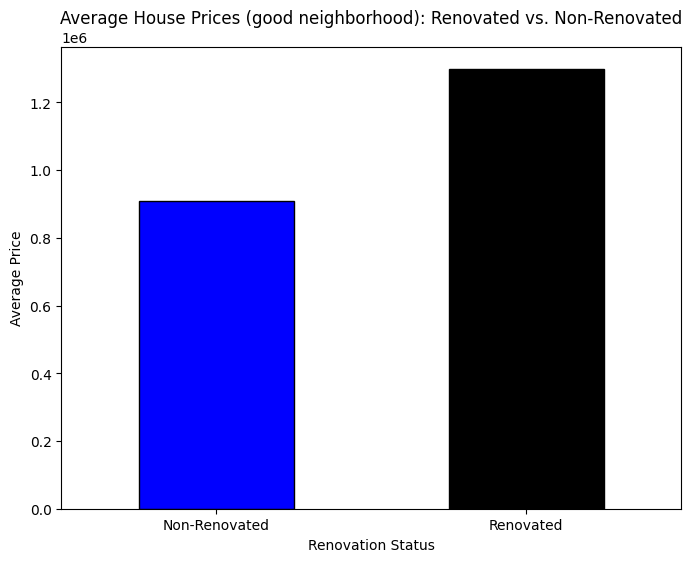

In [76]:
#Good neighborhood houses 
# Create a new column for renovation status
historical_houses_in_good_neighborhoods['renovated'] = historical_houses_in_good_neighborhoods['yr_renovated'].apply(lambda x: pd.notnull(x) and x != 0)

# Calculate average prices for renovated and non-renovated houses
renovation_prices = historical_houses_in_good_neighborhoods.groupby('renovated')['price'].mean()

# Plot comparison
plt.figure(figsize=(8, 6))
renovation_prices.plot(kind='bar', color=['blue', 'black'], edgecolor='black')
plt.title('Average House Prices (good neighborhood): Renovated vs. Non-Renovated')
plt.xlabel('Renovation Status')
plt.ylabel('Average Price')
plt.xticks(ticks=[0, 1], labels=['Non-Renovated', 'Renovated'], rotation=0)
plt.show()

In [77]:
#Calculate percentage increase from non-renovated to renovated

# Create a binary column for renovation status
df_eda_cleaned['renovated'] = df_eda_cleaned['yr_renovated'].apply(lambda x: pd.notnull(x) and x != 0)
historical_houses_in_good_neighborhoods['renovated'] = historical_houses_in_good_neighborhoods['yr_renovated'].apply(lambda x: pd.notnull(x) and x != 0)

# Calculate average prices for renovated and non-renovated houses
renovation_prices_df_eda = df_eda_cleaned.groupby('renovated')['price'].mean()
renovation_prices_good_neigh = historical_houses_in_good_neighborhoods.groupby('renovated')['price'].mean()

# Extract prices for non-renovated and renovated houses for both datasets
non_renovated_price_all = renovation_prices_df_eda[False]
renovated_price_all = renovation_prices_df_eda[True]

non_renovated_price_good_neigh = renovation_prices_good_neigh[False]
renovated_price_good_neigh = renovation_prices_good_neigh[True]

# Calculate percentage increase for all houses
percentage_increase_all = ((renovated_price_all - non_renovated_price_all) / non_renovated_price_all) * 100

# Calculate percentage increase for good neighborhoods
percentage_increase_good_neigh = ((renovated_price_good_neigh - non_renovated_price_good_neigh) / non_renovated_price_good_neigh) * 100

# Display results
print(f"Percentage increase in price for renovated houses (All Houses): {percentage_increase_all:.2f}%")
print(f"Percentage increase in price for renovated houses (Good Neighborhoods): {percentage_increase_good_neigh:.2f}%")


Percentage increase in price for renovated houses (All Houses): 44.49%
Percentage increase in price for renovated houses (Good Neighborhoods): 42.82%


/var/folders/mv/6m38j0cs28b4zwc_3g6h8jkh0000gn/T/ipykernel_33813/1413041607.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historical_houses_in_good_neighborhoods['renovated'] = historical_houses_in_good_neighborhoods['yr_renovated'].apply(lambda x: pd.notnull(x) and x != 0)


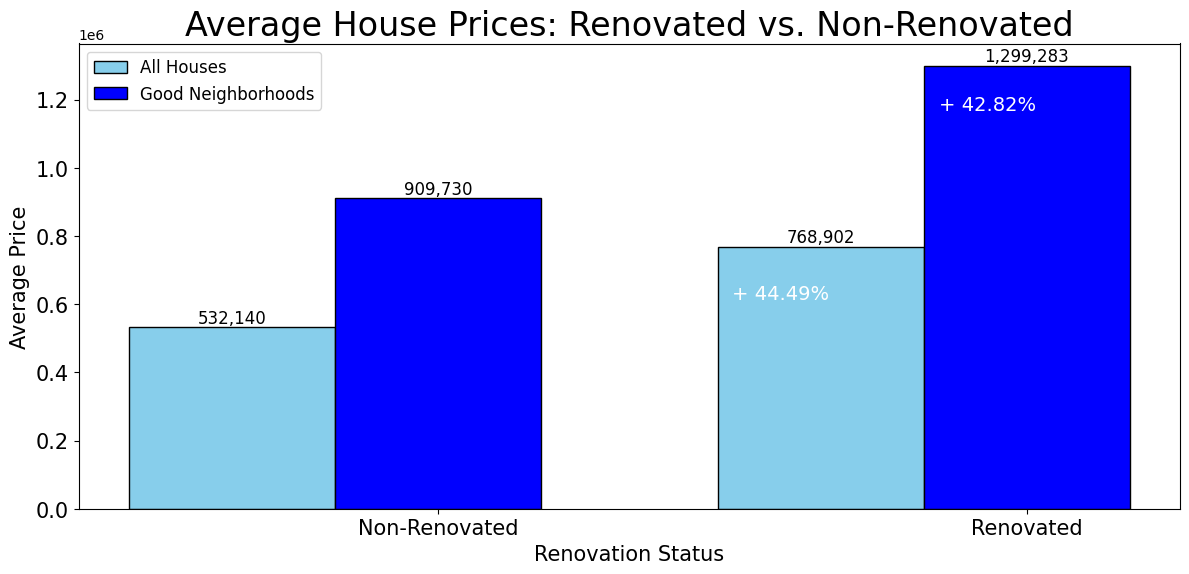

In [81]:
#Compare price difference between renovated and non-renovated houses (all houses vs houses in good neighborhood)

# Prepare data for plotting
data = {
    'All Houses': renovation_prices_df_eda,
    'Good Neighborhoods': renovation_prices_good_neigh
}

# Define colors for each dataset
colors = {
    'All Houses': ['skyblue'],  
    'Good Neighborhoods': ['blue'] 
}

# Plot comparison
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = range(len(renovation_prices_df_eda))

# Plot bars for each dataset
for i, (label, prices) in enumerate(data.items()):
    bars = plt.bar([x + i * bar_width for x in index], prices, bar_width, 
                   label=label, color=colors[label], edgecolor='black')

    # Add labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:,.0f}', 
                 ha='center', va='bottom', fontsize=12)

# Customize plot
plt.title('Average House Prices: Renovated vs. Non-Renovated', fontsize=24)
plt.xlabel('Renovation Status', fontsize=15)
plt.ylabel('Average Price', fontsize=15)
plt.xticks([x + bar_width for x in index], ['Non-Renovated', 'Renovated'], fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=12)
plt.tight_layout() 

# Annotate percentage increases on the plot
plt.text(0.85, max(renovation_prices_df_eda) * 0.8, 
         f'+ {percentage_increase_all:.2f}%', color='white', fontsize=14)
plt.text(1.2, max(renovation_prices_good_neigh) * 0.9, 
         f'+ {percentage_increase_good_neigh:.2f}%', color='white', fontsize=14)

# Show plot
plt.show()


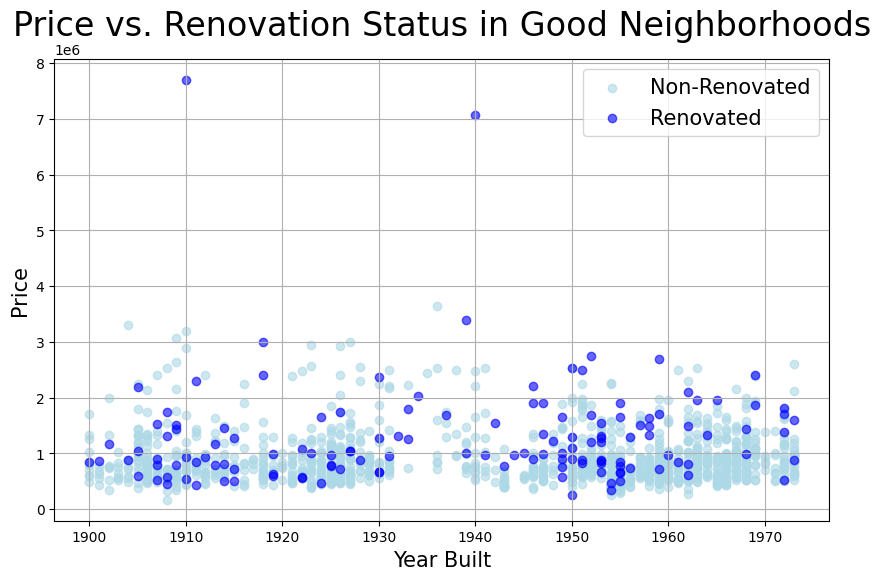

In [79]:
#correlation between price and renovation status for houses in good neighborhoods

# Scatter plot of price vs renovation status
plt.figure(figsize=(10, 6))

# Plot non-renovated houses
non_renovated = historical_houses_in_good_neighborhoods[historical_houses_in_good_neighborhoods['renovated'] == False]
plt.scatter(non_renovated['yr_built'], non_renovated['price'], color='lightblue', alpha=0.6, label='Non-Renovated')

# Plot renovated houses
renovated = historical_houses_in_good_neighborhoods[historical_houses_in_good_neighborhoods['renovated'] == True]
plt.scatter(renovated['yr_built'], renovated['price'], color='blue', alpha=0.6, label='Renovated')

# Customize plot
plt.title('Price vs. Renovation Status in Good Neighborhoods', fontsize=24)
plt.xlabel('Year Built', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.legend(fontsize=15)
plt.grid(True)

# Show plot
plt.show()


# Step 4: 

# Identify which features have the most significant impact on house prices
### Perform a correlation analysis and visualise

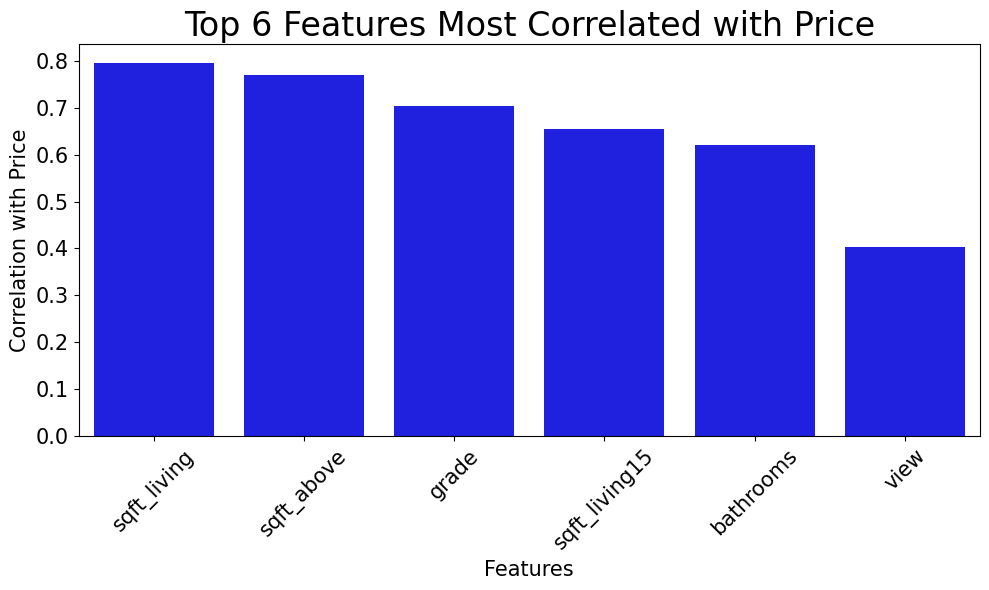

In [52]:
#Only look at historical houses in good neighborhoods
# Calculate correlation matrix
corr_matrix = historical_houses_in_good_neighborhoods.corr()

# Extract correlation of features with price
corr_with_price = corr_matrix['price'].sort_values(ascending=False)
# Select the top 6 features (excluding 'price' itself)
top_features = corr_with_price[1:7]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.index, y=top_features.values, color='blue') 
plt.title('Top 6 Features Most Correlated with Price', fontsize=24) 
plt.xlabel('Features', fontsize=15)  
plt.ylabel('Correlation with Price', fontsize=15)  
plt.xticks(rotation=45, fontsize=15) 
plt.yticks(fontsize=15) 
plt.tight_layout()  
plt.show()

In [61]:
#formate date 
type(df_eda_cleaned['date'][7])
df_eda_cleaned['date'] = pd.to_datetime(df_eda_cleaned['date'], format='%Y-%m-%d')

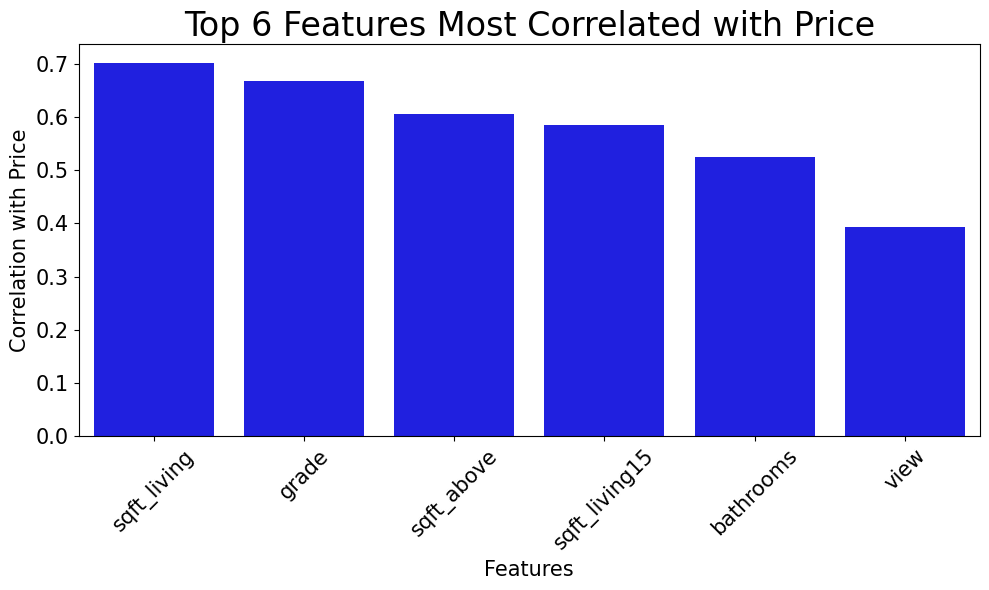

In [59]:
#Only look at historical houses in good neighborhoods
# Calculate correlation matrix
corr_matrix = df_eda_cleaned.corr()

# Extract correlation of features with price
corr_with_price = corr_matrix['price'].sort_values(ascending=False)
# Select the top 6 features (excluding 'price' itself)
top_features = corr_with_price[1:7]

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.index, y=top_features.values, color='blue') 
plt.title('Top 6 Features Most Correlated with Price', fontsize=24) 
plt.xlabel('Features', fontsize=15)  
plt.ylabel('Correlation with Price', fontsize=15)  
plt.xticks(rotation=45, fontsize=15) 
plt.yticks(fontsize=15) 
plt.tight_layout()  
plt.show()

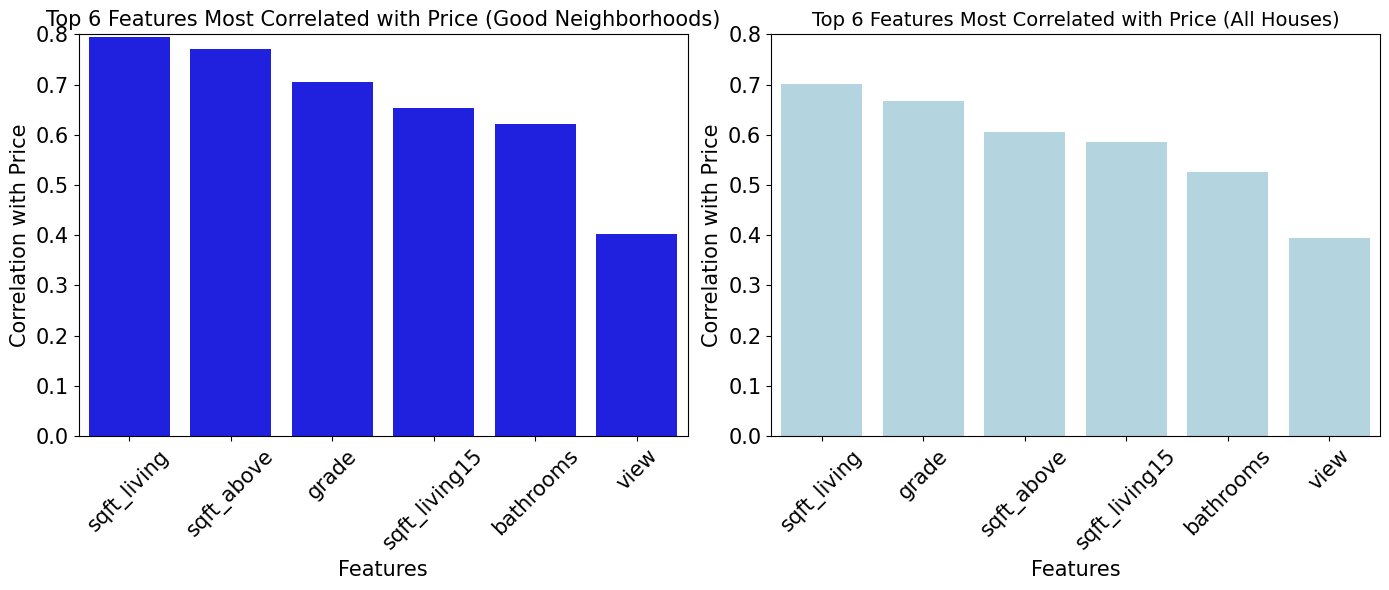

In [64]:
#compare

# Calculate correlation matrices and extract top 6 features
# Historical houses in good neighborhoods
corr_matrix_good_neighborhoods = historical_houses_in_good_neighborhoods.corr()
corr_with_price_good_neighborhoods = corr_matrix_good_neighborhoods['price'].sort_values(ascending=False)
top_features_good_neighborhoods = corr_with_price_good_neighborhoods[1:7]

# All houses (df_eda_cleaned)
corr_matrix_all_houses = df_eda_cleaned.corr()
corr_with_price_all_houses = corr_matrix_all_houses['price'].sort_values(ascending=False)
top_features_all_houses = corr_with_price_all_houses[1:7]

# Plotting
plt.figure(figsize=(14, 6))

# Define y-axis limits - make sure both are same
y_axis_limits = (0.0, 0.8)

# Plot for historical houses in good neighborhoods
plt.subplot(1, 2, 1)
sns.barplot(x=top_features_good_neighborhoods.index, y=top_features_good_neighborhoods.values, color='blue')
plt.title('Top 6 Features Most Correlated with Price (Good Neighborhoods)', fontsize=15)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation with Price', fontsize=15)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(y_axis_limits)  # Set y-axis limits

# Plot for all houses
plt.subplot(1, 2, 2)
sns.barplot(x=top_features_all_houses.index, y=top_features_all_houses.values, color='lightblue')
plt.title('Top 6 Features Most Correlated with Price (All Houses)', fontsize=14)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation with Price', fontsize=15)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(y_axis_limits)  # Set y-axis limits

plt.tight_layout()
plt.show()



# Step 5: 

# Find other correlations
## e.g. heatmap

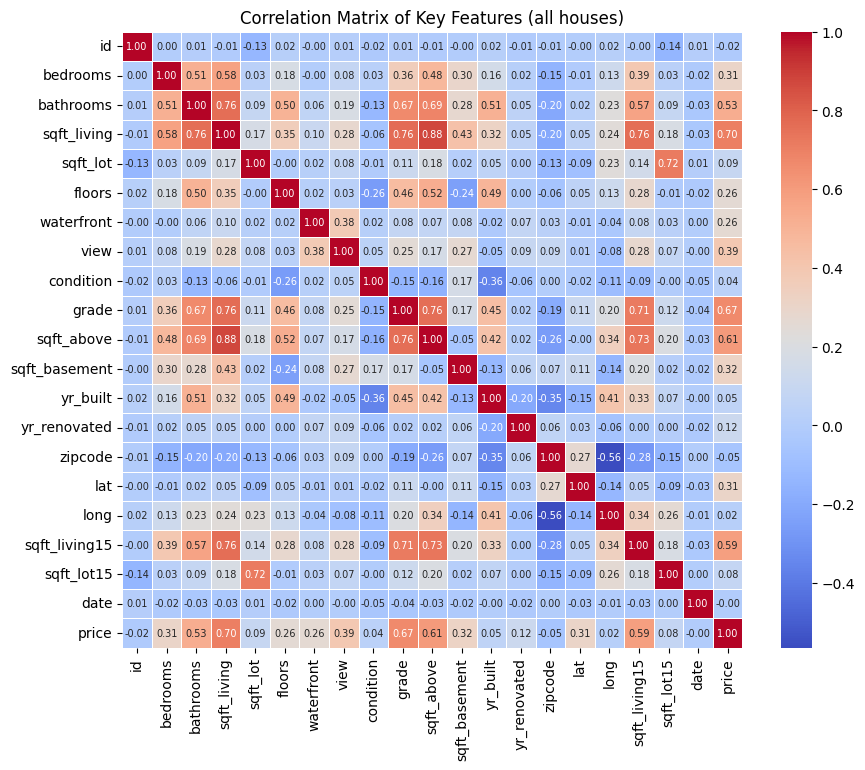

In [73]:
# show all correlations all houses
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_all_houses, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, annot_kws={"size": 7} )
plt.title("Correlation Matrix of Key Features (all houses)")
plt.show()


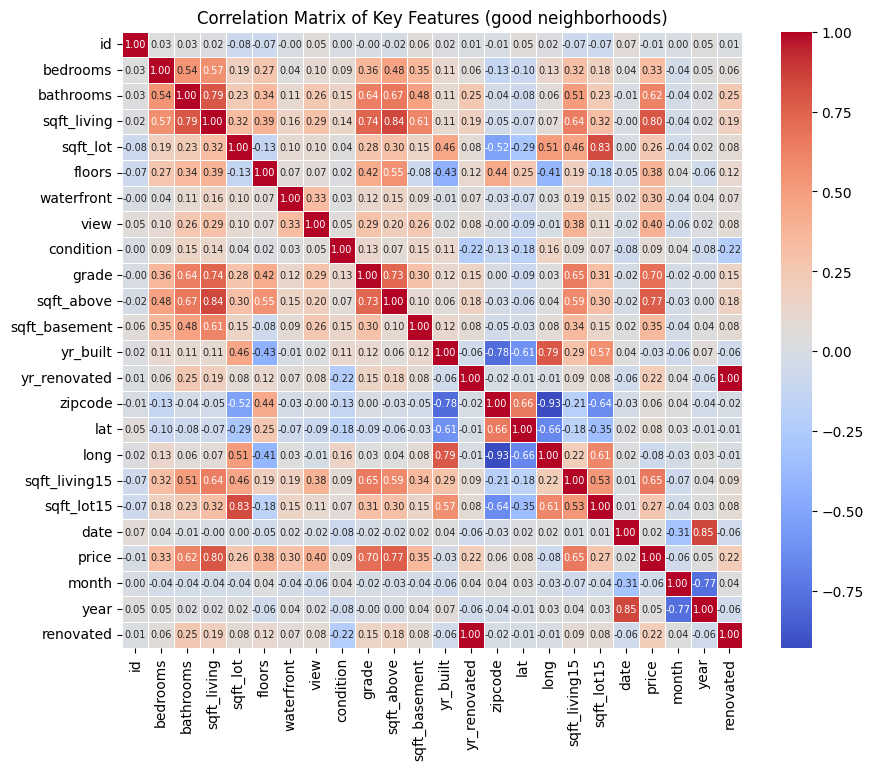

In [74]:
# show all correlations all houses
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_good_neighborhoods, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, annot_kws={"size": 7} )
plt.title("Correlation Matrix of Key Features (good neighborhoods)")
plt.show()

In [ ]:
#Formate
# Drop rows with missing values
historical_houses_in_good_neighborhoods = historical_houses_in_good_neighborhoods.dropna()